In [1]:
import ufl

import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from dolfinx.fem import locate_dofs_geometrical
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

import shutil
import typing


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.dot)
inner = Infix(ufl.inner)


def vector(*args):
    return ufl.as_vector(tuple(args))


from ufl import TrialFunction, TestFunction, FacetNormal, SpatialCoordinate
from ufl import dx, ds, exp, sym, tr, sqrt
from ufl import nabla_div as div
from ufl import nabla_grad as grad
from ufl import as_matrix as matrix
from ufl import lhs, rhs

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return ufl.Identity(func_like.geometric_dimension())


# Classes:


def Function(space, func=None):
    """Function on new space. Without func just create a Function on space. 
    Args:
        space (FunctionSpace): New space
        function (): 
    \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
    \nVectors - fem.vector_Function,fem.vector_Constant, ufl_vector_function, callable vector_function, tuple_number
    Returns:
        fem.Function: Function
    """

    result = fem.Function(space)
    tupe = str(func.__class__)[8:-2]
    cord = SpatialCoordinate(space)

    # None
    if func == None:
        return result

    # fem.Function
    elif tupe == ('dolfinx.fem.function.Function'):
        expression = func

    # fem.Constant
    elif tupe == ('dolfinx.fem.function.Constant'):
        if len(func.ufl_shape) == 0: func2 = func.value + (cord[0] - cord[0])
        else:
            func2 = vector(*func.value) +\
                vector(*map(lambda x, y: x - y, cord, cord))
        expression = fem.Expression(func2, space.element.interpolation_points())

    # ufl object
    elif tupe[:3] == 'ufl':
        if len(func.ufl_shape) != 0:
            func2 = func + vector(*map(lambda x, y: x - y, cord, cord))
        else:
            func2 = func
        expression = fem.Expression(func2, space.element.interpolation_points())

    # Python function
    elif tupe == ('function'):
        expression = func

        # Number
    elif not hasattr(func, '__call__'):
        if hasattr(func, '__getitem__'):
            func2 = vector(*func) + vector(*map(lambda x, y: x - y, cord, cord))
        else:
            func2 = func + (cord[0] - cord[0])
        expression = fem.Expression(func2, space.element.interpolation_points())

    result.interpolate(expression)
    return result


def Constant(domain_space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace| domain): Space or domain
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return fem.Constant(domain_space, fem.petsc.PETSc.ScalarType(const))


def create_facet_markers(domain, bound_markers):
    """Mark facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function
    
    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


def DirichletBC(space, func, combined_marker):
    """Create Dirichlet condition

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function or Constant
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(mesh.meshtags, marker) - list or tuple, marker of boundary from Marked_facets - mesh.meshtags
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def get_exterior_facets():
        exterior_facets = mesh.exterior_facet_indices(domain.topology)
        return exterior_facets

    def all_dirichlet(dofs, func):
        if hasattr(func, 'function_space'):
            bc = fem.dirichletbc(dofs=dofs, value=func)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=func)
        return bc

    domain = space.mesh

    if combined_marker == 'All':
        facets = get_exterior_facets()
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == (tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )
    else:
        dofs = fem.locate_dofs_geometrical(space, marker=combined_marker)

    bc = all_dirichlet(dofs, func)

    return bc


# Solvers:
def NonLinear_Solver(problem, params={}, options={}, report=False):

    params0 = {
        'convergence_criterion': 'incremental',
        'tolerance': 1E-6,
        }
    params0.update(params)

    options0 = {
        'ksp_type': 'cg',
        'pc_type': 'gamg',
        'pc_factor_mat_solver_type': 'mumps',
        }
    options0.update(options)

    solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem=problem)

    solver.convergence_criterion = params0['convergence_criterion']
    solver.rtol = params0['tolerance']
    solver.report = report

    ksp = solver.krylov_solver
    opts = petsc4py.PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = options0['ksp_type']
    opts[f"{option_prefix}pc_type"] = options0['pc_type']
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = options0[
        'pc_factor_mat_solver_type']
    ksp.setFromOptions()
    return solver


# Post processing:


# Fix it for vectors
def errors_L(space, uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = space.mesh

    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph from fem.Function

    Args:
        fig (plt.Figure): Figure
        lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
        method (bool): Graph method True = tripcolor, False = tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on:
            ax.plot(data[0], data[1], 'o', markersize=2, color='grey')
        try:
            if natural_show:
                plot = ax.tripcolor(*data)
            else:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(*data, levels=levels)

            ax.set_aspect(1)
            fig.colorbar(plot, ax=ax)
        except:
            print(f'F:{u.name} = 0 or another error')
    return

In [11]:
class Problem:

    def __init__(
        self,
        a: ufl.Form,
        L: ufl.Form,
        u: fem.Function=None,
        bcs: typing.List[fem.petsc.DirichletBCMetaClass] = [],
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
            },
        ghost_opions={
            'addv': fem.petsc.PETSc.InsertMode.ADD,
            'mode': fem.petsc.PETSc.ScatterMode.REVERSE,
            },
        form_compiler_params={},
        jit_params={},
        ):

        def set_options(self):
            problem_prefix = f'dolfinx_solve_{id(self)}'
            self._solver.setOptionsPrefix(problem_prefix)
            opts = fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            self._solver.setFromOptions()
            self._A.setOptionsPrefix(problem_prefix)
            self._A.setFromOptions()
            self._b.setOptionsPrefix(problem_prefix)
            self._b.setFromOptions()

        if u is None:
            # Extract function space from TrialFunction (which is at the
            # end of the argument list as it is numbered as 1, while the
            # Test function is numbered as 0)
            self._u = fem.Function(a.arguments()[-1].ufl_function_space())
        else:
            self._u = u
        self._bcs = bcs

        self._a = fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._A = fem.petsc.assemble_matrix(self._a, self._bcs)
        self._A.assemble()

        self._L = fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._b = fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
            )
        self._solver.setOperators(self._A)
        set_options(self)

        self._ghost_opions = ghost_opions

    def prepare_b(self):
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        fem.petsc.assemble_vector(self._b, self._L)

        fem.petsc.apply_lifting(self._b, [self._a], bcs=[self._bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
            )
        fem.petsc.set_bc(self._b, self._bcs)

    def solve(self):
        self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return self._u

    @classmethod
    def KSP_types():
        return fem.petsc.PETSc.KSP.Type

    @classmethod
    def PC_types():
        return fem.petsc.PETSc.PC.Type

    @classmethod
    def ghost_updates():
        return (fem.petsc.PETSc.InsertMode, fem.petsc.PETSc.ScatterMode)

    # @classmethod
    # def HYPER_types():
    # return fem.petsc.PETSc

    @property
    def L(self) -> fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver

In [3]:
N = 100
domain = mesh.create_unit_square(
    MPI.COMM_WORLD,
    N,
    N,     # cell_type=mesh.CellType.quadrilateral,
    )
V = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)
n = FacetNormal(domain=domain)
u, v = TrialFunction(V), TestFunction(V)
dx = ufl.Measure('cell', subdomain_id='everywhere')

uEx = 1 + x**2 + 2 * y**2
uD = 1
s = 1

r = Constant(V, 10)
k = Constant(V, 1)

g = -2*(n|dot|grad(uEx))
f = -div(grad(uEx))

bound_markers = [
    (1, lambda x: np.isclose(x[0], 0)),
    (2, lambda x: np.isclose(x[0], 1)),
    (3, lambda x: np.isclose(x[1], 0)),
    (4, lambda x: np.isclose(x[1], 1)),
    ]
marked_facets = create_facet_markers(
    domain=domain,
    bound_markers=bound_markers,
    )
create_connectivity(domain=domain)
ds = ufl.Measure('ds', domain=domain, subdomain_data=marked_facets)

bcs = [
    DirichletBC(V, Function(V, uD), (marked_facets, 1)),
    DirichletBC(V, Function(V, uD), (marked_facets, 3)),
    ]

F = k * (grad(u)|dot|grad(v)) * dx - f*v*dx
F += g * v * ds(4)
# F += r * (u-s) * v * ds(3)

In [12]:
problem = Problem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        },
    )
uS = problem.solve()
uS.name = 'Numeric'

uEx_f = Function(V, uEx)
uEx_f.name = 'Exact'

In [5]:
try:
    shutil.rmtree('/home/VTK/3.4Poisson_Int_marker_Files')
except:
    print('Directory empty yet')

with io.VTKFile(
    domain.comm, '/home/VTK/3.4Poisson_Int_marker_Files/Poisson.pvd', 'w'
    ) as file:
    file.write_function([uS, uEx_f])

F:Numeric = 0 or another error


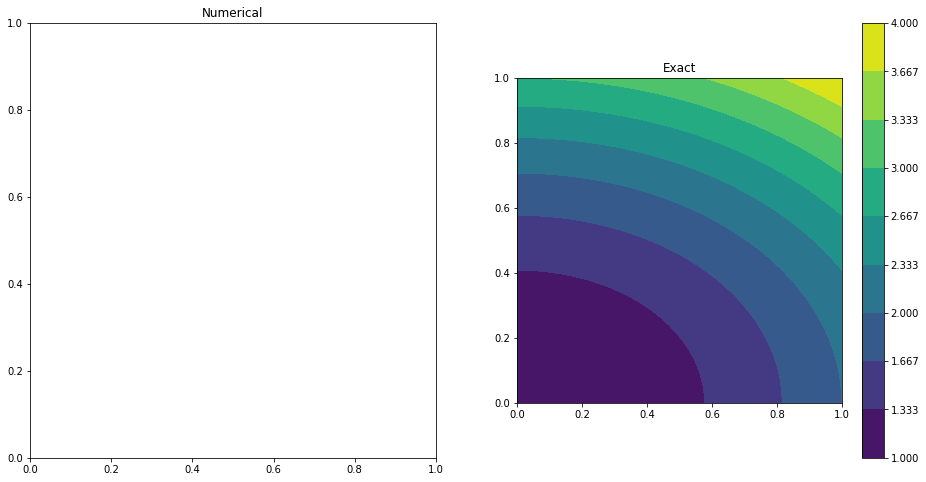

In [13]:
fig, (ax,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)

lis = [
    [uS, ax, 'Numerical'],
    [uEx_f, ax2, 'Exact'],
    ]

graph2D(
    fig=fig,
    lists=lis,
    natural_show=False,     # points_on=True,
    )

# Div grad problem

In [7]:
ufl_func = uEx
func = uEx_f
const = k_c
pyfunc = lambda x: x[1] + x[0]
pyconst = 6
list_of_types = [ufl_func, func, const, pyfunc, pyconst]
V2 = VectorFunctionSpace(domain, ('CG', 1))


NameError: name 'k_c' is not defined

In [ ]:
f1 = Function(V, div(grad(uEx)))
print(f1.x.array[0:6], f1.x.array[:-6:-1])

V2 = VectorFunctionSpace(domain, ('CG', 1))
f21 = Function(V2, grad(uEx))
f22 = Function(V, div(f21))
print(f22.x.array[0:6], f22.x.array[:-6:-1])

f31 = Function(V2, grad(uEx_f))
f32 = Function(V, div(f31))
print(f32.x.array[0:6], f32.x.array[:-6:-1])

# f4 = Function(
#     V,
#     div(ufl.( grad(uEx_f))),
#     )
# print(f4.x.array[0:6], f4.x.array[:-6:-1])

[6. 6. 6. 6. 6. 6.] [6. 6. 6. 6. 6.]
[6. 6. 6. 6. 6. 6.] [6. 6. 6. 6. 6.]
[6. 6. 6. 6. 6. 6.] [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0000000e+00 8.8817842e-12]


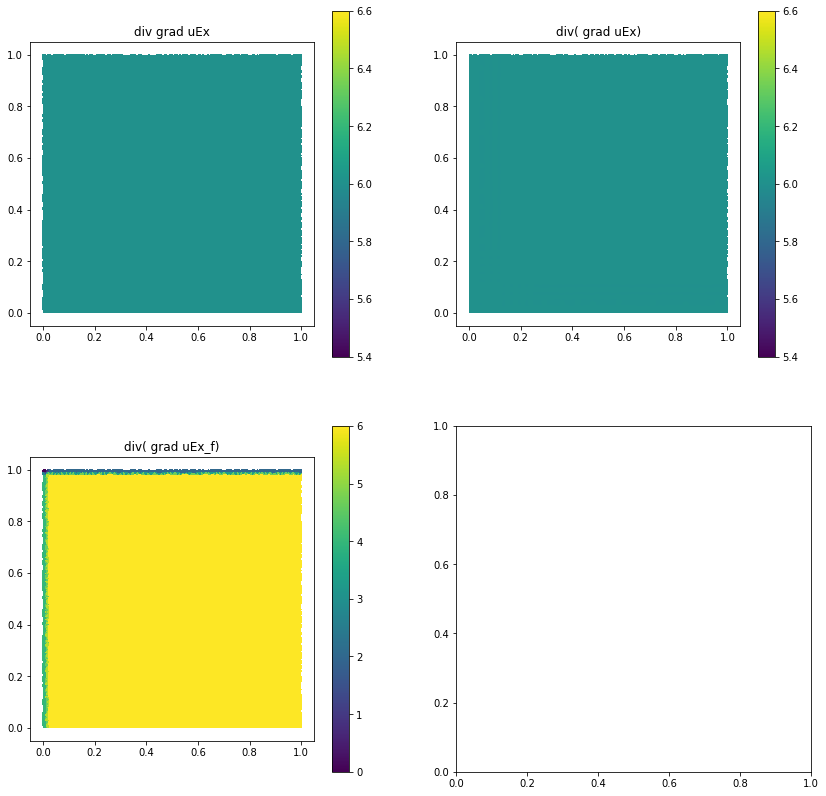

In [ ]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(14, 14)

lis = [
    [f1, ax, 'div grad uEx'],
    [f22, ax2, 'div( grad uEx)'],
    [f32, ax3, 'div( grad uEx_f)'],     # [f4, ax4, 'div grad uEx_f+vector'],
    ]

graph2D(
    fig=fig,
    lists=lis,
    natural_show=True,
    points_on=False,
    )


In [ ]:
# with io.VTKFile(
#     domain.comm, '/home/VTK/3.4Poisson_Int_marker_Files/Test.pvd', 'w'
#     ) as file:
#     file.write_function([uS, uEx])